In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
import os

expr_dir = os.path.expanduser('~/Documents/586Project/VPoserModelFiles/vposer_v2_05')
assert os.path.isdir(expr_dir), f"VPoser model directory not found: {expr_dir}"


In [4]:
from human_body_prior.tools.model_loader import load_model
from human_body_prior.models.vposer_model import VPoser

vp, ps = load_model(expr_dir, model_code=VPoser,
                    remove_words_in_model_weights='vp_model.',
                    disable_grad=True,
                    comp_device=device)
vp = vp.to(device)

2025-04-12 19:11:35.762 | INFO     | human_body_prior.tools.model_loader:load_model:77 - No GPU detected. Loading on CPU!
2025-04-12 19:11:35.853 | INFO     | human_body_prior.tools.model_loader:load_model:97 - Loaded model in eval mode with trained weights: /Users/roawaal/Documents/586Project/VPoserModelFiles/vposer_v2_05/snapshots/V02_05_epoch=13_val_loss=0.03.ckpt


In [5]:
import os
import torch
from human_body_prior.tools.model_loader import load_model
from human_body_prior.models.vposer_model import VPoser

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define and verify path to VPoser model directory
expr_dir = os.path.expanduser('~/Documents/586Project/VPoserModelFiles/vposer_v2_05')
assert os.path.isdir(expr_dir), f"VPoser model directory not found: {expr_dir}"

# Load VPoser model
vp, ps = load_model(expr_dir,
                    model_code=VPoser,
                    remove_words_in_model_weights='vp_model.',
                    disable_grad=True,
                    comp_device=device)
vp = vp.to(device)
print("VPoser model loaded successfully.")


2025-04-12 19:11:52.894 | INFO     | human_body_prior.tools.model_loader:load_model:77 - No GPU detected. Loading on CPU!
2025-04-12 19:11:52.937 | INFO     | human_body_prior.tools.model_loader:load_model:97 - Loaded model in eval mode with trained weights: /Users/roawaal/Documents/586Project/VPoserModelFiles/vposer_v2_05/snapshots/V02_05_epoch=13_val_loss=0.03.ckpt


Using device: cpu
VPoser model loaded successfully.


In [7]:
import torch
import os
import numpy as np

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Path to the VPoser model directory (update with your actual path)
expr_dir = os.path.expanduser('~/Documents/586Project/VPoserModelFiles/vposer_v2_05')  # Replace with actual path

# Load VPoser model (Ensure load_model function is correctly defined)
vp, ps = load_model(expr_dir, model_code=VPoser,
                    remove_words_in_model_weights='vp_model.',
                    disable_grad=True,
                    comp_device=device)
vp = vp.to(device)

# Path to AMASS CMU subset directory (update with your actual path)
amass_dir = os.path.expanduser('~/Documents/586Project/AMASS_CMUsubset/')   # Replace with actual path

# Get all .npz files in the AMASS directory
npz_files = [f for f in os.listdir(amass_dir) if f.endswith('.npz')]
npz_files.sort()  # Sort files for consistent order

# Example: Load one of the .npz files (replace with the correct filename)
sample_amass_fname = os.path.join(amass_dir, npz_files[0])

# Load body pose data from the file
amass_body_pose = np.load(sample_amass_fname)['poses'][:, 3:66]  # This assumes the pose has 69 values per frame
amass_body_pose = torch.from_numpy(amass_body_pose).type(torch.float).to(device)

print('amass_body_pose.shape', amass_body_pose.shape)  # Shape should be (N, 63) after slicing


2025-04-12 19:17:59.023 | INFO     | human_body_prior.tools.model_loader:load_model:77 - No GPU detected. Loading on CPU!
2025-04-12 19:17:59.085 | INFO     | human_body_prior.tools.model_loader:load_model:97 - Loaded model in eval mode with trained weights: /Users/roawaal/Documents/586Project/VPoserModelFiles/vposer_v2_05/snapshots/V02_05_epoch=13_val_loss=0.03.ckpt


Using device: cpu
amass_body_pose.shape torch.Size([2751, 63])


In [10]:
# Run the encoder on all frames
encoded_output = vp.encode(amass_body_pose)  # Assuming this is returning a Normal distribution

# Check the encoded output to verify the structure
print(encoded_output)  # This will show the Normal distribution and its attributes

# Access the latent mean and standard deviation from the Normal distribution
amass_body_poZ_mean = encoded_output.loc  # The 'loc' attribute holds the mean of the distribution
amass_body_poZ_scale = encoded_output.scale  # The 'scale' attribute holds the std deviation

# Optionally, if you need to use the mean (latents), you can do:
print('amass_body_poZ_mean.shape', amass_body_poZ_mean.shape)

# If you want to proceed with the mean latent vector:
amass_body_poZ = amass_body_poZ_mean  # Assuming you want the mean as the latent vector

# Print the shape of the latent vector
print('amass_body_poZ.shape', amass_body_poZ.shape)


Normal(loc: torch.Size([2751, 32]), scale: torch.Size([2751, 32]))
amass_body_poZ_mean.shape torch.Size([2751, 32])
amass_body_poZ.shape torch.Size([2751, 32])


In [12]:
# Run the decoder on all frames
# Run the decoder on the latent vector
decoded_output = vp.decode(amass_body_poZ)  # Decode the latent vector obtained from the encoder

# Check the structure of the decoded output
print(decoded_output)  # This will show the full decoded output (including 'pose_body', etc.)

# Assuming 'pose_body' is the part of the decoded output we care about
amass_body_pose_rec = decoded_output['pose_body'].contiguous().view(-1, 63)  # Reshape as needed

# Print the shape of the decoded body pose
print('amass_body_pose_rec.shape', amass_body_pose_rec.shape)


{'pose_body': tensor([[[ 8.7309e-02, -4.7282e-02,  9.0301e-03],
         [-3.2094e-02, -2.0606e-02, -2.3989e-03],
         [ 6.1520e-02, -1.2503e-02, -3.0286e-02],
         ...,
         [-2.0957e-01,  4.2302e-01, -1.0425e-01],
         [-4.1418e-01, -2.5764e-01,  3.7918e-01],
         [-3.6112e-01,  3.5136e-02, -2.4811e-03]],

        [[ 8.8403e-02, -4.6971e-02,  9.2425e-03],
         [-3.1755e-02, -2.0514e-02, -2.0833e-03],
         [ 6.5321e-02, -1.3585e-02, -2.9663e-02],
         ...,
         [-2.1397e-01,  4.1570e-01, -1.0110e-01],
         [-4.1698e-01, -2.5815e-01,  3.8049e-01],
         [-3.6186e-01,  3.2168e-02, -1.6654e-03]],

        [[ 8.8865e-02, -4.6865e-02,  9.6485e-03],
         [-3.1082e-02, -2.0688e-02, -1.7717e-03],
         [ 6.7033e-02, -1.3817e-02, -2.9602e-02],
         ...,
         [-2.1813e-01,  4.1269e-01, -9.9726e-02],
         [-4.1959e-01, -2.5833e-01,  3.8415e-01],
         [-3.6702e-01,  3.0539e-02, -4.7251e-03]],

        ...,

        [[-1.2151e-01, -

In [17]:
import os
import torch
import numpy as np
from human_body_prior.body_model.body_model import BodyModel

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device is', device)

# Correct path to your SMPL model file
bm_fname = os.path.expanduser('~/Documents/586Project/VPoserModelFiles/smplx_neutral_model.npz')

# Confirm the file exists
assert os.path.isfile(bm_fname), f"Model file not found at: {bm_fname}"

# Load the body model
bm = BodyModel(bm_fname=bm_fname).to(device)


device is cpu


In [18]:
import torch
import trimesh
from human_body_prior.tools.omni_tools import copy2cpu as c2c

# Assume `amass_body_pose` is the original body pose (from dataset)
# Assume `amass_body_pose_rec` is the decoded body pose (from VPoser decoder)

# Create the body models from the original and reconstructed poses
originalPoses = {'pose_body': amass_body_pose}  # Original poses
recoveredPoses = {'pose_body': amass_body_pose_rec}  # Reconstructed poses

# Initialize the body model for the original and reconstructed poses
bmodelorig = bm(**originalPoses)  # Pass original poses to the model
bmodelreco = bm(**recoveredPoses)  # Pass reconstructed poses to the model

# Copy the vertices from GPU to CPU if necessary
vorig = c2c(bmodelorig.v)  # Get vertices for the original poses
vreco = c2c(bmodelreco.v)  # Get vertices for the reconstructed poses

# Get the faces (mesh connectivity) for the model
faces = c2c(bm.f)  # Faces of the mesh (assuming bm.f contains the face connectivity)

# Get the shape of the vertices: T is the number of time steps (or frames), num_verts is the number of vertices per pose
T, num_verts = vorig.shape[:-1]  # The shape excluding the last dimension (vertices)

# You can visualize a specific frame (e.g., frame 0) to check the body pose
frame_idx = 0  # For example, visualizing the first frame

# Extract vertices for a specific frame (frame_idx)
verts_original = vorig[frame_idx]  # Original body pose for frame 0
verts_reconstructed = vreco[frame_idx]  # Reconstructed body pose for frame 0

# Create 3D meshes for the original and reconstructed body poses
mesh1 = trimesh.base.Trimesh(verts_original, faces)  # Mesh for original body pose
mesh1.visual.vertex_colors = [254, 254, 254]  # Set color to white (grey) for the original pose

mesh2 = trimesh.base.Trimesh(verts_reconstructed, faces)  # Mesh for reconstructed body pose
mesh2.visual.vertex_colors = [254, 66, 200]  # Set color to purple for the reconstructed pose

# Optionally, apply translation to visualize both meshes together
mesh2.apply_translation([1, 0, 0])  # Shift the reconstructed mesh to the right (along x-axis)

# Visualize the two meshes in a 3D scene
meshes = [mesh1, mesh2]  # Combine both meshes (original and reconstructed)
scene = trimesh.Scene(meshes)  # Create a scene to visualize the meshes

# Show the scene
scene.show()  # This opens a window to display the meshes


In [19]:
# Above: encode, decode
# Below: Transform

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the transformer model
class PosePredictionTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads=8, num_layers=6, hidden_dim=512):
        super(PosePredictionTransformer, self).__init__()

        # Transformer encoder layer
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # Linear layer to map output to pose dimension
        self.fc_out = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # Transformer expects input of shape [sequence_length, batch_size, input_dim]
        x = x.permute(1, 0, 2)  # [batch_size, sequence_length, input_dim] -> [sequence_length, batch_size, input_dim]
        x = self.transformer_encoder(x)  # Apply transformer encoding
        x = x.permute(1, 0, 2)  # Back to [batch_size, sequence_length, input_dim]
        output = self.fc_out(x)  # Map to pose dimension
        return output


In [21]:
# Example of loading your pose sequences (in latent space)
# amass_body_pose is the sequence of body poses in latent space (e.g., from a VPoser encoder)
# Each pose is of size (1, 32) and the sequence length is the number of frames in the sequence

# Example: Use the first 10 frames as input, the next 10 frames as target
input_seq = amass_body_pose[0:10]  # Example: First 10 frames as input
target_seq = amass_body_pose[10:20]  # Example: Next 10 frames as target

# Convert to torch tensors
input_seq = torch.tensor(input_seq, dtype=torch.float).unsqueeze(0)  # Add batch dimension
target_seq = torch.tensor(target_seq, dtype=torch.float).unsqueeze(0)


/var/folders/22/cyt666h549z5wdq3v47q2hqm0000gn/T/ipykernel_9871/1221448490.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(input_seq, dtype=torch.float).unsqueeze(0)  # Add batch dimension
/var/folders/22/cyt666h549z5wdq3v47q2hqm0000gn/T/ipykernel_9871/1221448490.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_seq = torch.tensor(target_seq, dtype=torch.float).unsqueeze(0)


In [27]:
# Define the model
input_dim = 32  # Latent space dimension (from VPoser)
output_dim = 63  # SMPL body pose dimension (output of the decoder)

model = PosePredictionTransformer(input_dim, output_dim).to(device)


/Users/roawaal/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [28]:
# Loss function (MSE) and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [25]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    predicted_output = model(input_seq)  # Predict future poses in latent space
    
    # Compute loss
    loss = criterion(predicted_output, target_seq)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 5 epochs
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



AssertionError: was expecting embedding dimension of 32, but got 63

In [29]:
# Another model, give up the above one

In [30]:
import os
import numpy as np
import torch
from human_body_prior.models.vposer_model import VPoser
from human_body_prior.tools.model_loader import load_model

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load VPoser

# vposer, _ = load_model(vp_model_path, model_code='vposer')   updated call

vp_model_path = os.path.expanduser('~/Documents/586Project/VPoserModelFiles/vposer_v2_05')

vposer, _ = load_model(vp_model_path, model_code=VPoser)  # pass the class, not string
vposer = vposer.to(device)
vposer.eval()
# Set AMASS path
amass_dir = os.path.expanduser('~/Documents/586Project/AMASS_CMUsubset/')
npz_files = sorted([f for f in os.listdir(amass_dir) if f.endswith('.npz')])

latent_means = []

# Loop through all AMASS files
for fname in npz_files:
    path = os.path.join(amass_dir, fname)
    data = np.load(path)
    pose = data['poses'][:, 3:66]  # Remove global rotation and hands

    pose_tensor = torch.tensor(pose, dtype=torch.float32).to(device)

    with torch.no_grad():
        posterior = vposer.encode(pose_tensor)
        mean = posterior.loc.cpu().numpy()
        latent_means.append(mean)

# Stack and save
latent_poses_array = np.concatenate(latent_means, axis=0)
output_path = os.path.expanduser('~/Documents/586Project/latent_poses.npz')
np.savez(output_path, latent_poses=latent_poses_array)
print(f"Saved {latent_poses_array.shape} latent vectors to {output_path}")


2025-04-12 19:34:36.277 | INFO     | human_body_prior.tools.model_loader:load_model:77 - No GPU detected. Loading on CPU!
2025-04-12 19:34:36.356 | INFO     | human_body_prior.tools.model_loader:load_model:97 - Loaded model in eval mode with trained weights: /Users/roawaal/Documents/586Project/VPoserModelFiles/vposer_v2_05/snapshots/V02_05_epoch=13_val_loss=0.03.ckpt


Saved (213368, 32) latent vectors to /Users/roawaal/Documents/586Project/latent_poses.npz


In [31]:
import os

# Step 2: Load latent pose vectors (ensure shape: [num_samples, latent_dim])
latent_path = os.path.expanduser('~/Documents/586Project/latent_poses.npz')
latent_data = np.load(latent_path, allow_pickle=True)
latent_poses = latent_data['latent_poses']  # shape: (N, D)

latent_poses = torch.tensor(latent_poses, dtype=torch.float32).to(device)
print('Latent poses shape:', latent_poses.shape)

Latent poses shape: torch.Size([213368, 32])


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

class PosePredictionTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, num_heads, dropout=0.1):
        super(PosePredictionTransformer, self).__init__()

        # Ensure input_dim is consistent with attention layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.num_heads = num_heads

        # Input projection layer to ensure input has the correct dimension
        self.input_projection = nn.Linear(input_dim, hidden_dim)

        # Transformer Encoder Layer
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,  # Should match input projection output size
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_layers
        )

        # Decoder for future pose prediction
        self.decoder = nn.Linear(hidden_dim, output_dim)  # Final output

    def forward(self, src, tgt):
        # Project input and target to the correct dimension
        src = self.input_projection(src)
        tgt = self.input_projection(tgt)
        
        # Apply transformer encoder
        memory = self.transformer_encoder(src)

        # Use memory to generate predictions (via decoder)
        output = self.decoder(memory)
        
        return output

input_dim = 64  # Make sure it's divisible by num_heads
hidden_dim = 128  # Can be adjusted as needed
output_dim = 63  # For SMPL pose output, or whatever output you need
num_layers = 4
num_heads = 4  # Ensure num_heads divides input_dim
batch_size = 32  # Set your desired batch size
sequence_length = 50  # Set your desired sequence length

# Initialize the model
model = PosePredictionTransformer(input_dim, hidden_dim, output_dim, num_layers, num_heads, dropout=0.1)

# Ensure input dimensions are correct
input_seq = torch.randn(batch_size, sequence_length, input_dim)  # Example input sequence
target_seq = torch.randn(batch_size, sequence_length, output_dim)  # Example target sequence

# Forward pass
predicted_output = model(input_seq, target_seq)

# Move model to device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Optimizer and Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Example of forward pass with random input
# Let's assume `input_seq` is the latent sequence for past poses and `target_seq` is for future poses.
# Here we generate random sequences for demonstration; replace them with actual data.

input_seq = torch.randn(32, 10, input_dim).to(device)  # batch_size x seq_length x input_dim
target_seq = torch.randn(32, 10, input_dim).to(device)  # batch_size x seq_length x output_dim

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    predicted_output = model(input_seq, target_seq)  # Predict future poses in latent space
    
    # Compute loss
    loss = criterion(predicted_output, target_seq)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 5 epochs
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1600x63 and 64x128)

In [37]:
class PosePredictionTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, num_heads, dropout=0.1):
        super(PosePredictionTransformer, self).__init__()

        # Ensure input_dim is consistent with attention layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.num_heads = num_heads

        # Input projection layer to ensure input has the correct dimension
        self.input_projection = nn.Linear(input_dim, hidden_dim)

        # Transformer Encoder Layer
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,  # Should match input projection output size
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_layers
        )

        # Decoder for future pose prediction
        self.decoder = nn.Linear(hidden_dim, output_dim)  # Final output

    def forward(self, src, tgt):
        # Project input and target to the correct dimension
        src = self.input_projection(src)
        tgt = self.input_projection(tgt)
        
        # Apply transformer encoder
        memory = self.transformer_encoder(src)

        # Use memory to generate predictions (via decoder)
        output = self.decoder(memory)
        
        return output

input_dim = 64  # Make sure it's divisible by num_heads
hidden_dim = 128  # Can be adjusted as needed
output_dim = 63  # For SMPL pose output, or whatever output you need
num_layers = 4
batch_size = 32  # Set your desired batch size
sequence_length = 50  # Set your desired sequence length
num_heads = 4  # Ensure num_heads divides input_dim

# Initialize the model
model = PosePredictionTransformer(input_dim, hidden_dim, output_dim, num_layers, num_heads, dropout=0.1)

# Ensure input dimensions are correct
input_seq = torch.randn(batch_size, sequence_length, input_dim)  # Example input sequence
target_seq = torch.randn(batch_size, sequence_length, output_dim)  # Example target sequence

# Forward pass
predicted_output = model(input_seq, target_seq)


NameError: name 'batch_size' is not defined

In [36]:
# Example input dimensions
input_dim = 64  # Make sure it's divisible by num_heads
hidden_dim = 128  # Can be adjusted as needed
output_dim = 63  # For SMPL pose output, or whatever output you need
num_layers = 4
num_heads = 4  # Ensure num_heads divides input_dim

# Initialize the model
model = PosePredictionTransformer(input_dim, hidden_dim, output_dim, num_layers, num_heads, dropout=0.1)

# Ensure input dimensions are correct
input_seq = torch.randn(batch_size, sequence_length, input_dim)  # Example input sequence
target_seq = torch.randn(batch_size, sequence_length, output_dim)  # Example target sequence

# Forward pass
predicted_output = model(input_seq, target_seq)


NameError: name 'batch_size' is not defined

In [40]:
import torch
import torch.nn as nn

class PosePredictionTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, num_heads, dropout=0.1):
        super(PosePredictionTransformer, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Ensure the projection layer matches input_dim and hidden_dim
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        self.output_projection = nn.Linear(hidden_dim, output_dim)

        # Encoder: Learn the representations from the input sequence
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, 
            nhead=num_heads, 
            dim_feedforward=hidden_dim, 
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_layers
        )

    def forward(self, src, tgt):
        # Project input and target to the correct dimension
        src = self.input_projection(src)
        tgt = self.input_projection(tgt)
        
        # Apply transformer encoder
        memory = self.transformer_encoder(src)
        
        # Apply transformer decoder using the encoder's output (memory)
        output = self.output_projection(memory)

        return output


# Example dimensions (ensure these match your data)
input_dim = 63  # Dimensionality of input latent space
hidden_dim = 128  # Hidden dimension (should be divisible by num_heads)
output_dim = 63  # Output latent dimension (same as input_dim if you're predicting poses in the same space)
num_layers = 4
num_heads = 8
dropout = 0.1

# Initialize the model
model = PosePredictionTransformer(input_dim, hidden_dim, output_dim, num_layers, num_heads, dropout)

# Example input sequence (make sure dimensions match)
batch_size = 32
sequence_length = 50
input_seq = torch.randn(batch_size, sequence_length, input_dim)  # Example input sequence
target_seq = torch.randn(batch_size, sequence_length, output_dim)  # Example target sequence

# Forward pass
predicted_output = model(input_seq, target_seq)
print(predicted_output.shape)  # Check the shape of the output


torch.Size([32, 50, 63])


In [41]:
# Example target sequence (make sure the dimensions match)
target_seq = torch.randn(batch_size, sequence_length, output_dim)  # Example target sequence

# Define loss function (e.g., MSE)
criterion = nn.MSELoss()

# Compute loss
loss = criterion(predicted_output, target_seq)

# Print the loss
print(f"Loss: {loss.item()}")


Loss: 1.3039888143539429


In [55]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming PosePredictionTransformer model is already defined

# Hyperparameters
input_dim = 63  # Example input dimension
hidden_dim = 128  # Example hidden dimension
output_dim = 63  # Example output dimension (same as input for latent pose prediction)
num_layers = 4  # Number of layers in transformer
num_heads = 8  # Number of attention heads in transformer
dropout = 0.1  # Dropout rate

batch_size = 32
sequence_length = 50
num_epochs = 20
learning_rate = 1e-4

# Initialize the model
model = PosePredictionTransformer(input_dim, hidden_dim, output_dim, num_layers, num_heads, dropout)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function (Mean Squared Error Loss)
criterion = nn.MSELoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Example training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    
    # Generate random input and target sequences (replace this with your actual data)
    input_seq = torch.randn(batch_size, sequence_length, input_dim).to(device)  # Example input sequence
    target_seq = torch.randn(batch_size, sequence_length, output_dim).to(device)  # Example target sequence
    
    # Forward pass
    predicted_output = model(input_seq, target_seq)  # Predict future poses in latent space
    
    # Compute loss
    loss = criterion(predicted_output, target_seq)
    
    # Backward pass and optimization
    optimizer.zero_grad()  # Zero the gradients
    loss.backward()  # Backpropagate the loss
    optimizer.step()  # Update model parameters
    
    # Print loss every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Example of model evaluation (optional, can be added at the end of training)
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    input_seq = torch.randn(batch_size, sequence_length, input_dim).to(device)  # Example input
    target_seq = torch.randn(batch_size, sequence_length, output_dim).to(device)  # Example target
    predicted_output = model(input_seq, target_seq)
    print("Predicted output:", predicted_output)
    
    #Not torch.save!!!!!!!!!!!!!!!!!!
    
    np.savez('predicted_output.npz', latent=predicted_output.cpu().numpy())
    print("Predicted output saved to 'predicted_output.npz'")

Epoch [5/20], Loss: 1.2868
Epoch [10/20], Loss: 1.2283
Epoch [15/20], Loss: 1.1779
Epoch [20/20], Loss: 1.1294
Predicted output: tensor([[[ 1.6168e-01,  3.5738e-01, -1.3484e-01,  ..., -1.7743e-01,
          -3.1603e-01, -5.3438e-01],
         [-4.3984e-01, -5.4681e-01, -3.6172e-01,  ...,  1.4455e-01,
           2.4694e-01,  1.5088e-01],
         [ 8.3160e-02, -1.1374e-01, -4.5567e-01,  ..., -1.9238e-01,
          -9.6700e-02,  4.7858e-01],
         ...,
         [-2.3285e-01, -2.5189e-01, -2.2984e-01,  ..., -1.1203e-01,
          -4.6336e-02, -7.1363e-02],
         [ 1.4679e-01,  3.8594e-01, -8.5370e-02,  ..., -4.8637e-01,
          -3.0373e-02, -2.5988e-01],
         [ 3.7958e-01,  6.6881e-01,  1.1534e-01,  ..., -9.2112e-01,
           2.7823e-02, -2.8884e-01]],

        [[ 7.8870e-03,  1.1959e-01,  1.1313e-01,  ..., -2.4603e-01,
           1.5966e-01, -2.1424e-01],
         [ 3.9226e-02,  2.5188e-01,  4.8506e-01,  ..., -5.8999e-01,
           1.7347e-01, -9.8693e-02],
         [ 7.99

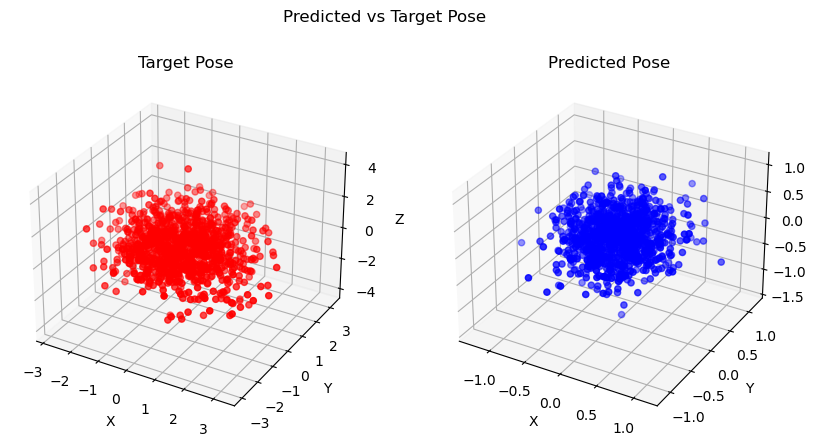

In [56]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_pose(predicted_output, target_seq, title="Predicted vs Target Pose"):
    # Assuming predicted_output and target_seq have shape (batch_size, sequence_length, num_joints * 3)
    # Reshape if necessary (num_joints * 3 for 3D coordinates)

    # For simplicity, we'll visualize the first sample in the batch
    predicted_output = predicted_output[0].cpu().detach().numpy()  # First batch item
    target_seq = target_seq[0].cpu().detach().numpy()  # First batch item
    
    # Assuming each pose has 21 joints (3 coordinates per joint)
    num_joints = 21  # Adjust based on the number of joints
    predicted_output = predicted_output.reshape(-1, 3)  # Reshaping to (num_joints, 3)
    target_seq = target_seq.reshape(-1, 3)  # Reshaping to (num_joints, 3)

    # Create 3D plot
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(121, projection='3d')
    
    # Plot target pose
    ax.scatter(target_seq[:, 0], target_seq[:, 1], target_seq[:, 2], color='r', label='Target Pose')
    ax.set_title("Target Pose")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    ax = fig.add_subplot(122, projection='3d')
    
    # Plot predicted pose
    ax.scatter(predicted_output[:, 0], predicted_output[:, 1], predicted_output[:, 2], color='b', label='Predicted Pose')
    ax.set_title("Predicted Pose")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    plt.suptitle(title)
    plt.show()

# Example usage
with torch.no_grad():
    input_seq = torch.randn(batch_size, sequence_length, input_dim).to(device)  # Example input
    target_seq = torch.randn(batch_size, sequence_length, output_dim).to(device)  # Example target
    predicted_output = model(input_seq, target_seq)
    
    # Visualize the predicted output vs target
    plot_3d_pose(predicted_output, target_seq)


In [45]:
import trimesh

# Assuming 'vorig' and 'vreco' are the original and reconstructed poses respectively, 
# and 'faces' defines the connectivity between vertices (mesh faces).
# You can replace these with your actual vertex and face data.

meshes = []
for fIdx in range(0, 200, 10):  # Loop over the sequence, adjusting the step size as needed
    # Visualize original pose
    verts = vorig[fIdx]  # Get vertices from the original pose
    mesh1 = trimesh.base.Trimesh(verts, faces)  # Create mesh from vertices and faces
    mesh1.visual.vertex_colors = [254, 254, 254]  # Set color to white for original pose
    mesh1.apply_translation([0, 0, fIdx * 0.07])  # Apply translation for temporal separation in Z-axis
    meshes.append(mesh1)  # Add to list of meshes
    
    # Visualize reconstructed pose
    verts = vreco[fIdx]  # Get vertices from the reconstructed pose
    mesh2 = trimesh.base.Trimesh(verts, faces)  # Create mesh from vertices and faces
    mesh2.visual.vertex_colors = [254, 150, 200]  # Set color to pink for reconstructed pose
    mesh2.apply_translation([0, 0, fIdx * 0.07])  # Apply translation for temporal separation in Z-axis
    meshes.append(mesh2)  # Add to list of meshes

# Create and display the scene
scene = trimesh.Scene(meshes)
scene.show()  # This will allow interactive 3D viewing with mouse controls


In [59]:
# Load the predicted latent poses from .npz
data = np.load('predicted_output.npz')
print("Keys in the .npz file:", data.files)

# Assuming the latent sequence is saved under the key 'latent'
latent_sequence = torch.tensor(data['latent'], dtype=torch.float32).to(device)  # Shape: [T, 32]

# Add batch dimension if needed
if latent_sequence.ndimension() == 2:
    latent_sequence = latent_sequence.unsqueeze(0)  # Shape: [1, T, 32]

# Decode VPoser latent vectors
decoded = vp.decode(latent_sequence)  # Returns pose_body (axis-angle)

# Remove batch dimension if added
pose_body = decoded['pose_body'].squeeze(0)  # Shape: [T, 63] or [T, 21*3]

# SMPL input dict (example: zero translation and shape)
pose_batch = pose_body.shape[0]
smpl_input = {
    'pose_body': pose_body,
    'pose_hand': torch.zeros([pose_batch, bm.num_hand_pose], device=device),
    'root_orient': torch.zeros([pose_batch, 3], device=device),
    'trans': torch.zeros([pose_batch, 3], device=device),
    'betas': torch.zeros([1, 16], device=device).expand(pose_batch, -1),
}

# Generate body vertices
body = bm(**smpl_input)
verts_sequence = body.v.detach().cpu().numpy()
faces = bm.f.cpu().numpy()

# Visualize using trimesh
meshes = []
for i in range(0, pose_batch, 10):  # every 10th frame
    mesh = trimesh.Trimesh(vertices=verts_sequence[i], faces=faces)
    mesh.visual.vertex_colors = [255, 180, 220]  # Optional: Add color to the vertices
    mesh.apply_translation([0, 0, i * 0.07])  # Apply some translation to avoid overlap
    meshes.append(mesh)

# Create a scene and show the meshes
scene = trimesh.Scene(meshes)
scene.show()

Keys in the .npz file: ['latent']


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1600x63 and 32x512)

In [65]:
# Load predicted latent poses from .npz
# Load latent sequence
data = np.load('predicted_output.npz')
latent_sequence = torch.tensor(data['latent'], dtype=torch.float32).to(device)  # [T, 32]

# Ensure correct shape for VPoser
if latent_sequence.ndim == 3:
    latent_sequence = latent_sequence.squeeze(0)  # Remove batch dim if present

# Decode poses (assuming VPoser accepts [T, 32])
decoded = vp.decode(latent_sequence)  # Output: {'pose_body': [T, 63]}
pose_body = decoded['pose_body']

# Generate SMPL meshes (rest of your code)
smpl_input = {
    'pose_body': pose_body,
    'pose_hand': torch.zeros([pose_body.shape[0], bm.num_hand_pose], device=device),
    'root_orient': torch.zeros([pose_body.shape[0], 3], device=device),
    'trans': torch.zeros([pose_body.shape[0], 3], device=device),
    'betas': torch.zeros([1, 16], device=device).expand(pose_body.shape[0], -1),
}
body = bm(**smpl_input)
verts_sequence = body.v.detach().cpu().numpy()

# Visualize with trimesh (as before)
# Generate SMPL mesh
with torch.no_grad():
    body = bm(**smpl_input)
    verts_sequence = body.vertices.detach().cpu().numpy()
    faces = bm.faces

# Visualize selected frames using trimesh
meshes = []
for i in range(0, pose_batch, max(1, pose_batch // 10)):  # Every ~10% frame
    mesh = trimesh.Trimesh(vertices=verts_sequence[i], faces=faces, process=False)
    mesh.visual.vertex_colors = [255, 180, 220]
    mesh.apply_translation([0, 0, i * 0.07])
    meshes.append(mesh)

scene = trimesh.Scene(meshes)
scene.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1600x63 and 32x512)

In [53]:
import numpy as np

data = np.load('predicted_output.npz')
print("Keys in the .npz file:", data.files)


Keys in the .npz file: ['predicted_output/data.pkl', 'predicted_output/byteorder', 'predicted_output/data/0', 'predicted_output/version', 'predicted_output/.data/serialization_id']


In [60]:
pip install torch numpy trimesh


Note: you may need to restart the kernel to use updated packages.


In [61]:
import numpy as np
import torch
import trimesh
from human_body_prior.tools import _btos
from human_body_prior.body_model import BodyModel
from human_body_prior.models.vposer_model import VPoser

# Load the .npz file containing the predicted latent poses
data = np.load('predicted_output.npz')

# Check what keys are in the file
print("Keys in the .npz file:", data.files)

# Assuming the latent sequence is stored under the key 'arr_0' or similar
latent_sequence = data['arr_0']  # Replace with the correct key if different
latent_sequence = torch.tensor(latent_sequence, dtype=torch.float32)


# Add batch dimension if needed (latent_sequence is expected to have shape [T, 32] or [1, T, 32])
if latent_sequence.ndimension() == 2:
    latent_sequence = latent_sequence.unsqueeze(0)  # Shape: [1, T, 32]

# Decode VPoser latent vectors
decoded = vp.decode(latent_sequence)  # Returns pose_body (axis-angle)

# Extract the body pose (axis-angle) for SMPL input
body_pose = decoded['pose_body']
pose_batch = body_pose.shape[0]

# SMPL input dict (example: zero translation and shape)
smpl_input = {
    'pose_body': body_pose,
    'pose_hand': torch.zeros([pose_batch, bm.num_hand_pose], device=device),
    'root_orient': torch.zeros([pose_batch, 3], device=device),
    'trans': torch.zeros([pose_batch, 3], device=device),
    'betas': torch.zeros([1, 16], device=device).expand(pose_batch, -1),
}

# Generate body vertices from SMPL model
body = bm(**smpl_input)
verts_sequence = body.v.detach().cpu().numpy()  # Shape: [T, V, 3]
faces = bm.f.cpu().numpy()  # SMPL faces

# Visualize using trimesh
meshes = []
for i in range(0, pose_batch, 10):  # Every 10th frame
    mesh = trimesh.Trimesh(vertices=verts_sequence[i], faces=faces)
    mesh.visual.vertex_colors = [255, 180, 220]  # Example color (RGB)
    mesh.apply_translation([0, 0, i * 0.07])  # Slight translation for each frame
    meshes.append(mesh)

# Create a scene with the meshes
scene = trimesh.Scene(meshes)
scene.show()


ImportError: cannot import name '_btos' from 'human_body_prior.tools' (/Users/roawaal/anaconda3/lib/python3.11/site-packages/human_body_prior/tools/__init__.py)

In [62]:
import trimesh

# Assuming 'vorig' is the original pose vertices, 
# 'predicted_output' is the predicted pose vertices, and 'faces' defines the connectivity between vertices (mesh faces).
# You can replace these with your actual vertex and face data.

meshes = []
for fIdx in range(0, 200, 10):  # Loop over the sequence, adjusting the step size as needed
    # Visualize original pose
    verts = vorig[fIdx]  # Get vertices from the original pose
    mesh1 = trimesh.base.Trimesh(verts, faces)  # Create mesh from vertices and faces
    mesh1.visual.vertex_colors = [254, 254, 254]  # Set color to white for original pose
    mesh1.apply_translation([0, 0, fIdx * 0.07])  # Apply translation for temporal separation in Z-axis
    meshes.append(mesh1)  # Add to list of meshes
    
    # Visualize predicted pose
    verts = predicted_output[fIdx]  # Get vertices from the predicted pose
    mesh2 = trimesh.base.Trimesh(verts, faces)  # Create mesh from vertices and faces
    mesh2.visual.vertex_colors = [254, 150, 200]  # Set color to pink for predicted pose
    mesh2.apply_translation([0, 0, fIdx * 0.07])  # Apply translation for temporal separation in Z-axis
    meshes.append(mesh2)  # Add to list of meshes

# Create and display the scene
scene = trimesh.Scene(meshes)
scene.show()  # This will allow interactive 3D viewing with mouse controls


IndexError: index 51 is out of bounds for axis 0 with size 50

In [64]:
# load predicted latent poses from a .npz file, decode them using VPoser, generate SMPL body meshes, and visualize the sequence using trimesh.